# Preprocessing the data to fit ConvLSTMs
The goal here is to convert this data to a suitable format that can be used as a channel input for the ConvLSTM.

## Interlude: picking longitude and latitude on HRRR doesn't work
But first, an interlude. Surely we can just use latitude and longitude in order to pick the exact areas that we want to subset, right...?

No. HRRR data uses a *curvilinear grid*, a result of Lambert-conformal conical projection. We're used to using a classic Cartesian coordinate system, using the geodetic coordinate system (latitude, longitude, etc.), on an equirectanfular projection (aka plate carree). This is what is used in the PWWB repo.
- Parameters of the LCC projection used by HRRR: https://ntrs.nasa.gov/api/citations/20160009371/downloads/20160009371.pdf
- Herbie discussion on HRRR, Cartesian coordinates, and curvilinear grids: https://github.com/blaylockbk/Herbie/discussions/45

In short, we can't use classic longitude and latitude units. Selecting points on a curvilinear grid based on longitude and latitude will require some preprocessing.
- Using Herbie to pick points on HRRR datasets: https://herbie.readthedocs.io/en/2024.5.0/user_guide/tutorial/accessor_notebooks/pick_points.html#Pick-points-from-HRRR-data

In [1]:
from herbie import Herbie

H = Herbie("2024-03-01", model="hrrr")
ds = H.xarray(":(?:TMP|DPT):2 m")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 46MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 292.5 292.5 292.4 ... 266.8 266.8
    d2m                  (y, x) float32 8MB 287.3 287.2 287.2 ... 262.2 262.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20240301/subset_e0ef89ff_...
    search:                  :(?:TMP|DPT):2 m

In [2]:
import pandas as pd
import numpy as np

points = pd.DataFrame(
    {
        "latitude": np.linspace(44, 45.5, 5),
        "longitude": np.linspace(-100, -101, 5),
        "stid": ["McIntosh", "Golden", "Fuji", "Gala", "Honeycrisp"],
    }
)
points

,latitude,longitude,stid
0,44.000,-100.00,McIntosh
1,44.375,-100.25,Golden
2,44.750,-100.50,Fuji
3,45.125,-100.75,Gala
4,45.500,-101.00,Honeycrisp


In [3]:
matched = ds.herbie.pick_points(points)
matched

<xarray.Dataset> Size: 320B
Dimensions:              (point: 5)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 40B 43.99 44.37 44.76 45.13 45.5
    longitude            (point) float64 40B 260.0 259.8 259.5 259.3 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  (point) float64 40B 0.8515 1.07 1.611 1.41 1.318
    point_latitude       (point) float64 40B 44.0 44.38 44.75 45.12 45.5
    point_longitude      (point) float64 40B -100.0 -100.2 -100.5 -100.8 -101.0
    point_stid           (point) object 40B 'McIntosh' 'Golden' ... 'Honeycrisp'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 20B 288.0 286.7 286.1 282.3 284.8
    d2m                  (point) float32 20B 268.8 271.8 270.5 274.1 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20240301/subset_e0ef89ff_...
    search:                  :(?:TMP|DPT):2 m

In [4]:
# swap dimesions to use the `point_stid` coordinate as the dimension instead
# allows us to select data by station id instead of point index
matched = matched.swap_dims({"point": "point_stid"})
matched.sel(point_stid="Honeycrisp")

<xarray.Dataset> Size: 128B
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             float64 8B 45.5
    longitude            float64 8B 259.0
    valid_time           datetime64[ns] 8B 2024-03-01
    gribfile_projection  object 8B None
    point_grid_distance  float64 8B 1.318
    point_latitude       float64 8B 45.5
    point_longitude      float64 8B -101.0
    point_stid           <U10 40B 'Honeycrisp'
Data variables:
    t2m                  float32 4B 284.8
    d2m                  float32 4B 270.5
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20240301/subset_e0ef89ff_...
    search:                  :(?:TMP|DPT):2 m

(-289442.889311017, -108684.3334160587, 605320.486730601, 849853.0858732163)

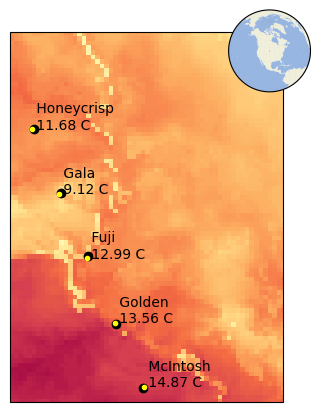

In [5]:
# plotting
from herbie.toolbox import EasyMap, pc, ccrs

ax = EasyMap(crs=ds.herbie.crs).ax
ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m,
    cmap="Spectral_r",
    vmax=290,
    vmin=270,
    transform=pc,
)

for i in matched.point_stid:
    z = matched.sel(point_stid=i)
    ax.scatter(z.longitude, z.latitude, color="k", transform=pc)
    ax.scatter(
        z.point_longitude, z.point_latitude, color="yellow", marker=".", transform=pc
    )
    ax.text(
        z.point_longitude,
        z.point_latitude,
        f" {z.point_stid.item()}\n {z.t2m.item()-273.15:.2f} C",
        transform=pc,
    )
ax.set_extent([-101, -99, 44, 46], crs=pc)
ax.EasyMap.INSET_GLOBE()
ax.adjust_extent()

## Example: Palisades fire
Now that we know how to picking longitude/latitude points on a curvilinear grid, let's do it to subset our data.

In [6]:
# pull data, place into xarray
H = Herbie(
    "2025-01-10",
    model="hrrr",
    product="sfc",
    fxx=0,
)

# examine xarray data
ds = H.xarray("MASSDEN")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


/home/mgraca/Workspace/hrrr-smoke-viz/venv/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


<xarray.Dataset> Size: 38MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2025-01-10
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 8.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2025-01-10
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    mdens                (y, x) float32 8MB 1.52e-09 1.52e-09 ... 8.855e-26
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/mgraca/data/hrrr/20250110/subset_d9ef9dd4_...
    search:                  MASSDEN

In [7]:
# coerce to numpy
ds_np = ds['mdens'].to_numpy()
ds_np

array([[1.52000e-09, 1.52000e-09, 1.52000e-09, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [1.52000e-09, 1.52000e-09, 1.52000e-09, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [1.60000e-09, 1.60000e-09, 1.60000e-09, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       ...,
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26],
       [8.85486e-26, 8.85486e-26, 8.85486e-26, ..., 8.85486e-26,
        8.85486e-26, 8.85486e-26]], shape=(1059, 1799), dtype=float32)

In [8]:
def plot(ds, coords=None, save=False):
    plt.figure()
    ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 8]).BORDERS().STATES().ax
    
    if coords != None:
        ax.set_extent(coords)
    
    p = ax.pcolormesh(
        ds.longitude,
        ds.latitude,
        ds.mdens * micro_per_k,
        transform=pc,
        #transform=ccrs.PlateCarree(),
        **paint.AQIPm25.kwargs2,
    )
    plt.colorbar(
        p,
        ax=ax,
        orientation="horizontal",
        pad=0.01,
        shrink=0.8,
        **paint.AQIPm25.kwargs2,
    )
    
    ax.set_title(
        f"{ds.model.upper()}: {H.product_description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}",
        loc="left",
    )
    ax.set_title(ds.mdens.GRIB_name, loc="right")

    if save:
        plt.savefig(f"images/hrrr_viz_{str(int(ds.step.item() / 3600000000000)).zfill(2)}.png")
        
    plt.show()
    plt.clf()